In [1]:
# import tarfile
# tar_path = 'data/'
# ball_video_path = 'Vid_A_ball.tar.xz'
# cup_video_path = 'Vid_B_cup.tar.xz'
# person_video_path = 'Vid_D_person.tar.xz'
# extract_to = 'data'

# with tarfile.open(tar_path+ball_video_path) as f:
#     f.extractall(extract_to)
    
# with tarfile.open(tar_path+cup_video_path) as f:
#     f.extractall(extract_to)
    
# with tarfile.open(tar_path+person_video_path) as f:
#     f.extractall(extract_to)
import torch
x = torch.rand(1, 2, 3, 3)
l= torch.rand(1, 1, 3, 3)
th = torch.Tensor([0.5])  # threshold
l = (l > th).float() * 1
print(x.shape)
print(x)
print(l)
l = l.view(-1)
x = torch.transpose(x, 0, 2)
x = torch.transpose(x, 1, 3)
x = x.reshape(-1, 2) 
print(x)
print(l)
# x = x.view(-1, x.shape[-1]*x.shape[-2])

torch.Size([1, 2, 3, 3])
tensor([[[[0.8748, 0.0617, 0.5620],
          [0.6027, 0.3868, 0.0819],
          [0.6651, 0.8138, 0.4877]],

         [[0.2362, 0.5186, 0.5989],
          [0.6299, 0.7005, 0.4778],
          [0.7744, 0.7584, 0.1961]]]])
tensor([[[[1., 1., 1.],
          [0., 1., 0.],
          [1., 1., 0.]]]])
tensor([[0.8748, 0.2362],
        [0.0617, 0.5186],
        [0.5620, 0.5989],
        [0.6027, 0.6299],
        [0.3868, 0.7005],
        [0.0819, 0.4778],
        [0.6651, 0.7744],
        [0.8138, 0.7584],
        [0.4877, 0.1961]])
tensor([1., 1., 1., 0., 1., 0., 1., 1., 0.])


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np

(240, 320)


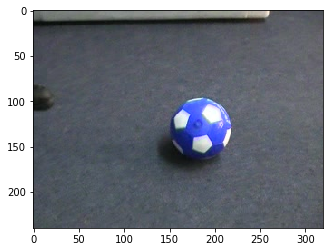

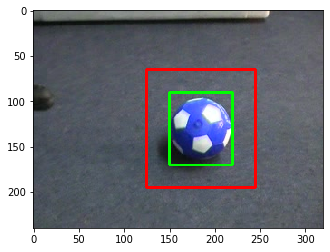

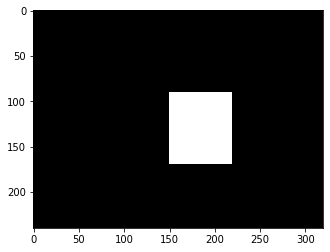

In [3]:
img_path = "./data/Vid_A_ball/img0125.jpg"

#Import image
orig_image = cv2.imread(img_path)
#Show the image with matplotlib
start_point = (150, 90)   
end_point = (220, 170)
padding = 25
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point[0]+padding, end_point[1]+padding)
# Blue color in BGR 
color = (0, 255, 0) 
color_pad = (255, 0, 0)
# Line thickness of 2 px 
thickness = 2
image = orig_image.copy()
image = cv2.rectangle(image, start_point, end_point, color, thickness) 
image = cv2.rectangle(image, start_point_pad, end_point_pad, color_pad, thickness) 


# label image
image_labels = np.zeros((orig_image.shape[0], orig_image.shape[1]))
image_labels[start_point[1]:end_point[1], start_point[0]:end_point[0]] = 1.0
print(image_labels.shape)
#Show the image with matplotlib
plt.imshow(orig_image)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(image_labels, cmap=plt.cm.gray)
plt.show()

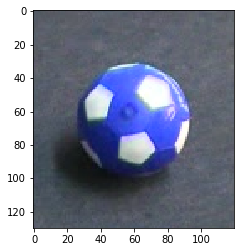

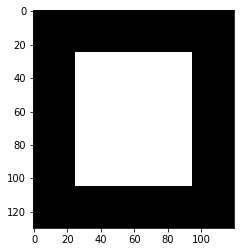

torch.Size([130, 120])
torch.Size([1, 3, 130, 120])
torch.Size([15600])


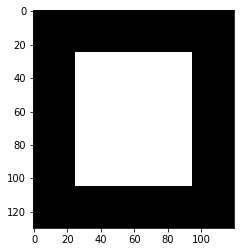

tensor([ 3025,  3026,  3027,  ..., 12572, 12573, 12574])
tensor([    0,     1,     2,  ..., 15597, 15598, 15599])


In [4]:
import torch

img = orig_image[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(img)
plt.show()

labels = image_labels[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(labels, cmap=plt.cm.gray)
plt.show()

img = np.moveaxis(img, -1, 0)
img = torch.tensor(img)
img = img.float()
img = img.unsqueeze(0)
labels = torch.tensor(labels)

print(labels.shape)
print(img.shape)
flatten_labels = labels.view(-1)
print(flatten_labels.shape)

test_flatten_labels = flatten_labels.reshape((labels.shape[0], labels.shape[1]))

plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

foreground = torch.where(flatten_labels == 1)[0]
background = torch.where(flatten_labels == 0)[0]
print(foreground)
print(background)

In [5]:
import random

def get_pixels_triplets(outputs, labels, batch_size, foreground, background):
    anchors = []
    postives = []
    negatives = []
#     print("len(background):", len(background))
#     print("len(foreground):", len(foreground))
#     print("len(outputs):", len(outputs))
    
    for _ in range(batch_size):
        anchor_label = random.randint(0, 1)
        if anchor_label == 0:
            # choose index from foreground and background
            anchor_idx = random.randrange(0, len(background))
            pos_idx = random.randrange(0, len(background))
            while anchor_idx == pos_idx:
                pos_idx = random.randrange(0, len(background))
            neg_idx = random.randrange(0, len(foreground))
            
            # get real index from outputs 
            anchor_idx = background[anchor_idx]
            pos_idx = background[pos_idx]
            neg_idx = foreground[neg_idx]
            
        elif anchor_label == 1:
            # choose index from foreground and background
            anchor_idx = random.randrange(0, len(foreground))
            pos_idx = random.randrange(0, len(foreground))
            while anchor_idx == pos_idx:
                pos_idx = random.randrange(0, len(foreground))
            neg_idx = random.randrange(0, len(background))
            
            # get real index from outputs
            anchor_idx = foreground[anchor_idx]
            pos_idx = foreground[pos_idx]
            neg_idx = background[neg_idx]
            
        anchors.append(outputs[anchor_idx])
        postives.append(outputs[pos_idx])
        negatives.append(outputs[neg_idx])
    return anchors, postives, negatives

In [6]:
import random

def get_triplet(labels, foreground, background):
    anchor_label = random.randint(0, 1)
    if anchor_label == 0:
        # choose index from foreground and background
        anchor_idx = random.randrange(0, len(background))
        pos_idx = random.randrange(0, len(background))
        while anchor_idx == pos_idx:
            pos_idx = random.randrange(0, len(background))
        neg_idx = random.randrange(0, len(foreground))

        # get real index from outputs 
        anchor_idx = background[anchor_idx]
        pos_idx = background[pos_idx]
        neg_idx = foreground[neg_idx]

    elif anchor_label == 1:
        # choose index from foreground and background
        anchor_idx = random.randrange(0, len(foreground))
        pos_idx = random.randrange(0, len(foreground))
        while anchor_idx == pos_idx:
            pos_idx = random.randrange(0, len(foreground))
        neg_idx = random.randrange(0, len(background))

        # get real index from outputs
        anchor_idx = foreground[anchor_idx]
        pos_idx = foreground[pos_idx]
        neg_idx = background[neg_idx]
    return anchor_idx, pos_idx, neg_idx

In [7]:
import time
from tqdm import tqdm

def train_model(model, criterion, image, labels, optimizer, foreground, background, num_epochs=25, batch_size=16, num_batches=1):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model.to(device)
    image = image.to(device)
    model.train()
    min_run_loss = np.inf
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        running_loss = []
#         for step in tqdm(range(batch_size*num_batches), desc="Training"):
        for _ in range(batch_size*num_batches):
            optimizer.zero_grad()
            outputs = model(image)
            anchor_idx, pos_idx, neg_idx = get_triplet(labels, foreground, background)
            loss = criterion(outputs, anchor_idx, pos_idx, neg_idx)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())
            mean_run_loss = np.mean(running_loss)
        if(mean_run_loss < min_run_loss):
            min_run_loss
        print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, num_epochs, np.mean(running_loss)))

def get_centroids(embeddings, foreground, background):
    centroid_background = embeddings[background].sum(0, keepdims=True) / len(background)
    centroid_foreground = embeddings[foreground].sum(0, keepdims=True) / len(foreground)
    return [centroid_background, centroid_foreground]

def embeddings_accuracy(embeddings, targets, shape, centriods, num_classes=2):
    correct = 0
    wrong = 0
    heat_map = np.zeros(len(embeddings))
    for i in range(num_classes):
        inds = np.where(targets==i)[0]
        for emb_idx, point in enumerate(embeddings[inds]):
            min_dist = np.inf
            min_dist_class = -1
            for class_idx, c in enumerate(centriods):
                dist = np.linalg.norm(c-point)
                if(dist < min_dist):
                    # print("point: ({}, {}) which in class {}, closer to centroid: ({}, {}) which in class {}".format(x, y, i, c[0], c[1], idx))
                    min_dist_class = class_idx
                    min_dist = dist
                    heat_map[inds[emb_idx]] = class_idx
            if(i == min_dist_class):
                correct += 1
            else:
                wrong += 1
    print("correct: {}, wrong: {}, accuracy: {}%".format(correct, wrong, (100.0*correct)/(correct + wrong)))
    heat_map = heat_map.reshape(shape)
    return heat_map

In [8]:
import pickle
def save_centroids(path):
    with open(path,'wb') as f:
        pickle.dump(centroids, f)
def load_centroids(path):
    centroids = None
    with open(path,'rb') as f:
        centroids = pickle.load(f)
    return centroids

def get_heat_map(embeddings, shape, centriods, num_classes=2):
    heat_map = np.zeros(len(embeddings))
    for emb_idx, embedding in enumerate(embeddings):
        min_dist = np.inf
        for class_idx, centriod in enumerate(centriods):
            dist = np.linalg.norm(centriod - embedding)
            if(dist < min_dist):
                min_dist = dist
                heat_map[emb_idx] = class_idx
    heat_map = heat_map.reshape(shape)
    return heat_map

In [9]:
import random as rd
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_PCA(embeddings, targets, out_features_size, classes, flat_first=False, is_3D=False,colors=None, pca_title='My PCA Graph', xlim=None, ylim=None, draw_PCA_per_varc=False, figure_size=(10,10), top_range_loadingfactors=None):
    # Generate random colors for each class
    if colors == None:
        colors = []
        r = lambda: rd.randint(0, 200) # (0, 255) not 255 to avoid colors diff than white
        for _ in range(len(classes)):
            colors.append('#%02X%02X%02X' % (r(),r(),r()))
    assert(len(colors) == len(classes))

    # First center and scale the data
    # After centering avg value for each gene will be 0
    # After scaling std for each gene will be 1
    embeddings_indecies = ['embedding' + str(i) for i in range(1, len(embeddings[0])+1)]
    df = pd.DataFrame(columns=embeddings_indecies, index=np.arange(1, len(embeddings)+1))
    for i in range(out_features_size):
        df.loc[:, embeddings_indecies[i]] = embeddings[:, i]
    # print(df.head())
    # print("Shape:", df.shape)
                          
    # scaled_data = preprocessing.scale(df.T) if(samples_are_columns) else preprocessing.scale(df)
    scaled_data = preprocessing.scale(df)
    pca = PCA()
    pca.fit(scaled_data) # calc loading scores for every pca
    pca_data = pca.transform(scaled_data) # generate coordinates    
    per_var = np.round(pca.explained_variance_ratio_*100, decimals=1) # Percentage of Explained Variance in %
    # labels to PCA number corresponding to Percentage of Explained Variance
    labels = ['PC' + str(i) for i in range(1, len(per_var)+1)] 
    
    # plot scree plot of loading factors 
    if draw_PCA_per_varc:
        plt.figure(figsize=figure_size)
        plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Component')
        plt.title('Scree Plot')
        plt.show()
    
    #the following code makes a fancy looking plot using PC1 and PC2
    pca_df = pd.DataFrame(pca_data, index=np.arange(1, len(embeddings)+1), columns=labels)
    # print(pca_df)
    if is_3D:
        ax = plt.figure(figsize=figure_size)
        ax = Axes3D(ax)
    else:
        plt.figure(figsize=figure_size)
    for i in range(len(classes)):
        inds = np.where(targets == i)[0]
        if is_3D:
            ax.scatter(pca_df.iloc[inds, 0], pca_df.iloc[inds, 1], pca_df.iloc[inds, 2], alpha=0.5, color=colors[i])
        else:
            plt.scatter(pca_df.iloc[inds, 0], pca_df.iloc[inds, 1], alpha=0.5, color=colors[i])
    if is_3D:
        if xlim:
            ax.xlim(xlim[0], xlim[1])
        if ylim:
            ax.ylim(ylim[0], ylim[1])

        ax.set_title(pca_title)
        ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
        ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
        ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))
        ax.legend(classes, loc=(1.04, 0))
    else:
        if xlim:
            plt.xlim(xlim[0], xlim[1])
        if ylim:
            plt.ylim(ylim[0], ylim[1])

        plt.title(pca_title)
        plt.xlabel('PC1 - {0}%'.format(per_var[0]))
        plt.ylabel('PC2 - {0}%'.format(per_var[1]))
        plt.legend(classes, loc=(1.04, 0))

        
    #########################
    #
    # Determine which genes had the biggest influence on PC1
    #
    #########################

    ## get the name of the top 10 measurements (genes) that contribute
    ## most to pc1.
    ## first, get the loading scores
    if top_range_loadingfactors != None:
        loading_scores = pd.Series(pca.components_[0], index=embeddings_indecies)
        ## now sort the loading scores based on their magnitude
        sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

        # get the names of the top 10 genes
        top_loading_factors = sorted_loading_scores[top_range_loadingfactors[0]: top_range_loadingfactors[1]].index.values

        ## print the gene names and their scores (and +/- sign)
        print(loading_scores[top_loading_factors])


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum()
    
    
    def forward(self, outputs, anchor_idx, pos_idx, neg_idx, size_average=True):
        anchor = outputs[anchor_idx].unsqueeze(0)
        pos = outputs[pos_idx].unsqueeze(0)
        neg = outputs[neg_idx].unsqueeze(0)

        distance_positive = nn.functional.pairwise_distance(anchor, pos)
        distance_negative = nn.functional.pairwise_distance(anchor, neg)
#         print("distance_positive:", distance_positive)
#         print("distance_negative:", distance_negative)
        
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

class EmbeddingNet(nn.Module):
    def __init__(self, last_out_channel=8):
        super(EmbeddingNet, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x


class EmbeddingNet2(nn.Module):
    def __init__(self, last_out_channel=32):
        super(EmbeddingNet2, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
#         print("x.shape:", x.shape)
#         x = x.view(-1, self.last_out_channel)
#         print("x.shape:", x.shape)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x
    
class EmbeddingNet3(nn.Module):
    def __init__(self, last_out_channel=64):
        super(EmbeddingNet3, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x
    
class EmbeddingNet4(nn.Module):
    def __init__(self, last_out_channel=256):
        super(EmbeddingNet4, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=128, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x

class EmbeddingNet5(nn.Module):
    def __init__(self, last_out_channel=256):
        super(EmbeddingNet5, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=128, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=self.last_out_channel, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x


class EmbeddingNet6(nn.Module):
    def __init__(self, last_out_channel=256):
        super(EmbeddingNet6, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=128, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(self.last_out_channel),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d):
#         torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.normal_(m.weight, mean=0, std=1.0)

## Experiment 1

In [10]:
# best accuracy in path = './model3_1.pt'
import torch.optim as optim
last_out_channel = 256
model = EmbeddingNet5(last_out_channel)
# model.apply(init_weights)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 10000.
criterion = TripletLoss(margin)
n_epochs = 20

In [11]:
model.load_state_dict(torch.load('./model5_3.pt'))

<All keys matched successfully>

In [12]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (15600, 256)
flatten_labels.shape: torch.Size([15600])
zeros count: 3399
not zeros count: 12201


correct: 14024, wrong: 1576, accuracy: 89.8974358974359%


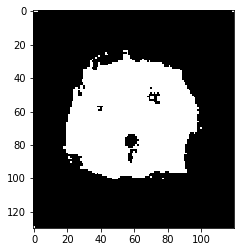

tensor([  0,   0,   0,  ..., 100, 100, 129])
tensor([ 3025,  3026,  3027,  ..., 12572, 12573, 12574])


In [13]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

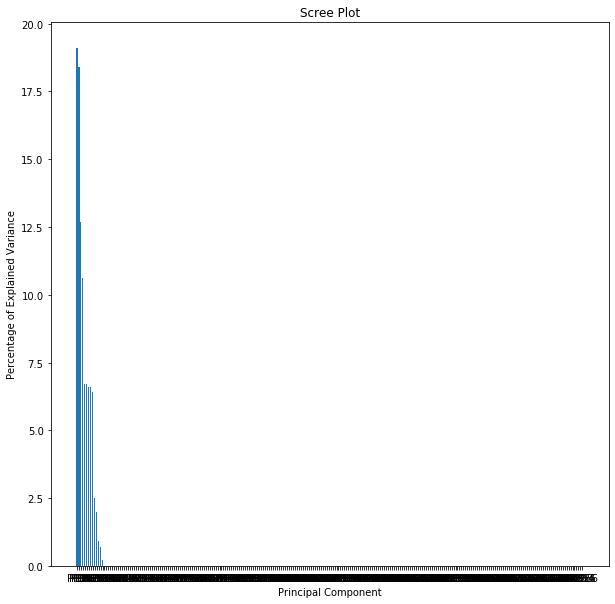

embedding80    -0.570215
embedding155   -0.561926
embedding229   -0.551647
dtype: float64


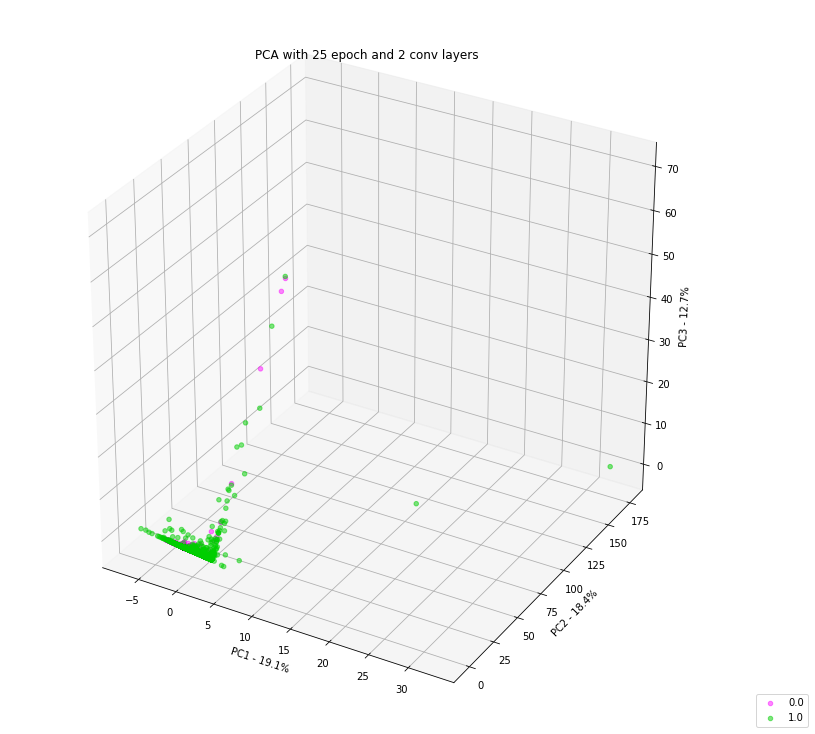

In [14]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

## Experiment 2

(240, 320)


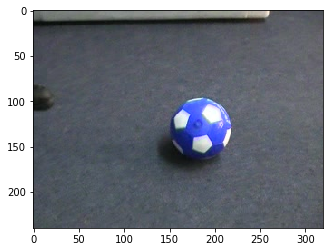

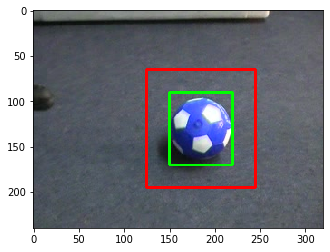

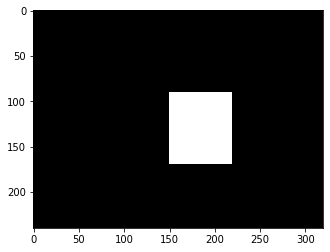

In [15]:
img_path = "./data/Vid_A_ball/img0125.jpg"

#Import image
orig_image = cv2.imread(img_path)
#Show the image with matplotlib
start_point = (150, 90)   
end_point = (220, 170)
padding = 25
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point[0]+padding, end_point[1]+padding)
# Blue color in BGR 
color = (0, 255, 0) 
color_pad = (255, 0, 0)
# Line thickness of 2 px 
thickness = 2
image = orig_image.copy()
image = cv2.rectangle(image, start_point, end_point, color, thickness) 
image = cv2.rectangle(image, start_point_pad, end_point_pad, color_pad, thickness) 


# label image
image_labels = np.zeros((orig_image.shape[0], orig_image.shape[1]))
image_labels[start_point[1]:end_point[1], start_point[0]:end_point[0]] = 1.0
print(image_labels.shape)
#Show the image with matplotlib
plt.imshow(orig_image)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(image_labels, cmap=plt.cm.gray)
plt.show()

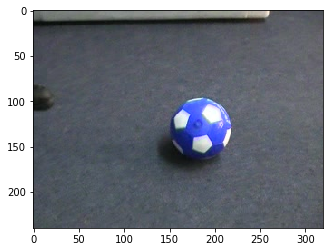

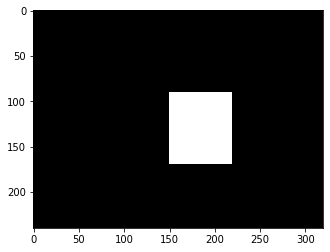

torch.Size([240, 320])
torch.Size([1, 3, 240, 320])
torch.Size([76800])


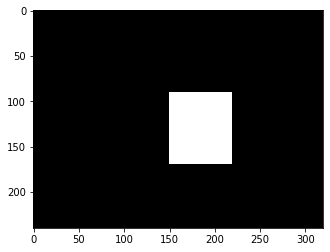

tensor([28950, 28951, 28952,  ..., 54297, 54298, 54299])
tensor([    0,     1,     2,  ..., 76797, 76798, 76799])


In [16]:
import torch

img = orig_image
plt.imshow(img)
plt.show()

labels = image_labels
plt.imshow(labels, cmap=plt.cm.gray)
plt.show()

img = np.moveaxis(img, -1, 0)
img = torch.tensor(img)
img = img.float()
img = img.unsqueeze(0)
labels = torch.tensor(labels)

print(labels.shape)
print(img.shape)
flatten_labels = labels.view(-1)
print(flatten_labels.shape)

test_flatten_labels = flatten_labels.reshape((labels.shape[0], labels.shape[1]))

plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

foreground = torch.where(flatten_labels == 1)[0]
background = torch.where(flatten_labels == 0)[0]
print(foreground)
print(background)

In [99]:
import torch.optim as optim
last_out_channel = 256
model = EmbeddingNet5(last_out_channel)
# model.apply(init_weights)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 10000.
criterion = TripletLoss(margin)
n_epochs = 20

In [109]:
model_path = 'model5_3'
centroids_path = 'Centroids/' + model_path + '_centroids' + '.pkl'

In [110]:
centroids = load_centroids(centroids_path)
model.load_state_dict(torch.load('Models/' + model_path + '.pt'))

<All keys matched successfully>

In [111]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (76800, 256)
flatten_labels.shape: torch.Size([76800])
zeros count: 3399
not zeros count: 73401


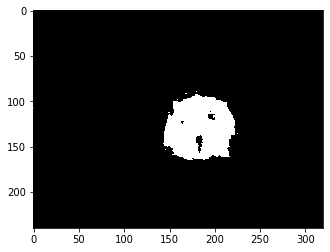

In [112]:
heat_map = get_heat_map(embeddings, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

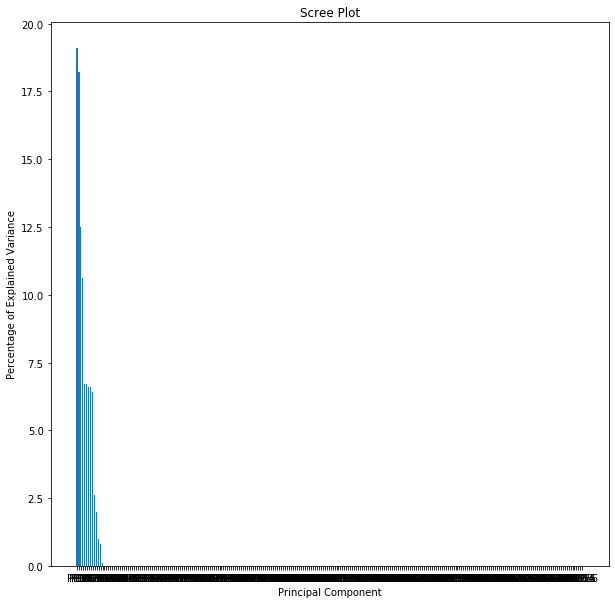

embedding80    -0.538962
embedding155   -0.530387
embedding229   -0.508573
dtype: float64


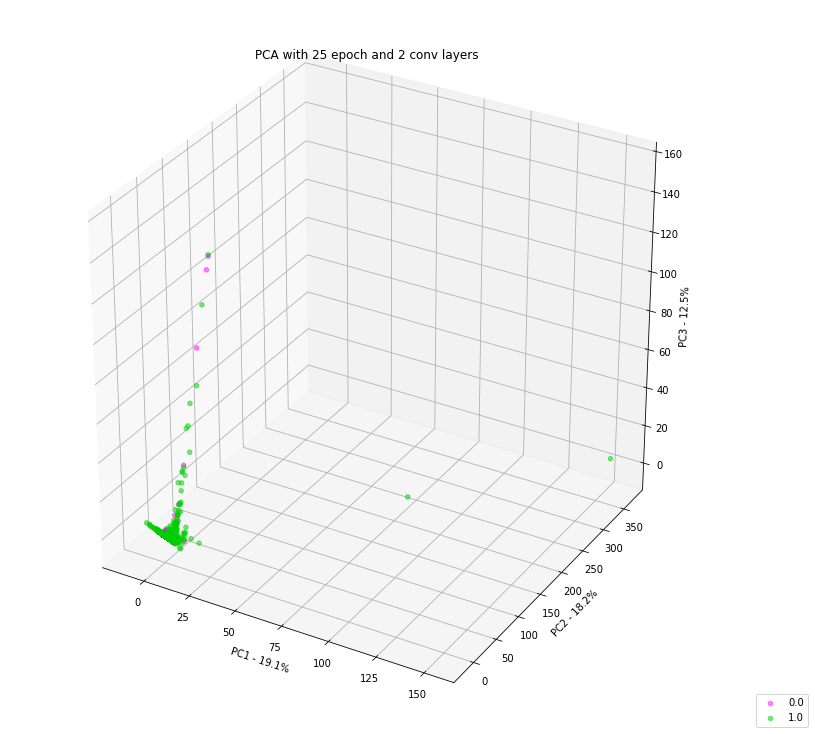

In [21]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

## Experiment 3 (model6_1)

In [65]:
img_path = "./data/Vid_A_ball/img0125.jpg"
model_path = './model6_1.pt'

In [66]:
#Import image
orig_image = cv2.imread(img_path)
#Show the image with matplotlib
start_point = (150, 90)   
end_point = (220, 170)
padding = 25
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point[0]+padding, end_point[1]+padding)
# Blue color in BGR 
color = (0, 255, 0) 
color_pad = (255, 0, 0)
# Line thickness of 2 px 
thickness = 2
image = orig_image.copy()
image = cv2.rectangle(image, start_point, end_point, color, thickness) 
image = cv2.rectangle(image, start_point_pad, end_point_pad, color_pad, thickness) 

(240, 320)


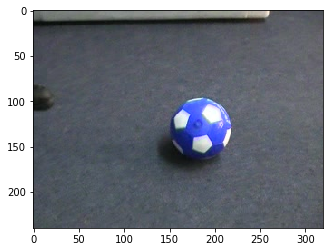

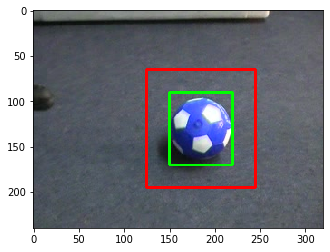

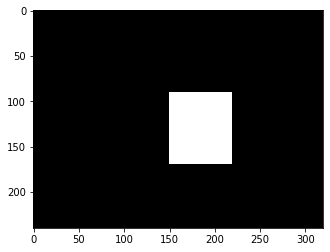

In [67]:
# label image
image_labels = np.zeros((orig_image.shape[0], orig_image.shape[1]))
image_labels[start_point[1]:end_point[1], start_point[0]:end_point[0]] = 1.0
print(image_labels.shape)
#Show the image with matplotlib
plt.imshow(orig_image)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(image_labels, cmap=plt.cm.gray)
plt.show()

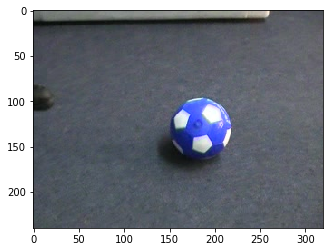

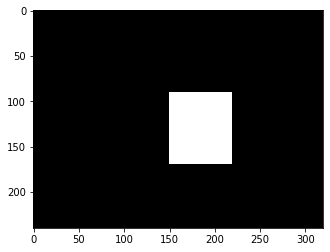

torch.Size([240, 320])
torch.Size([1, 3, 240, 320])
torch.Size([76800])


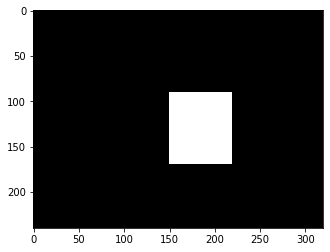

tensor([28950, 28951, 28952,  ..., 54297, 54298, 54299])
tensor([    0,     1,     2,  ..., 76797, 76798, 76799])


In [68]:
import torch

img = orig_image
plt.imshow(img)
plt.show()

labels = image_labels
plt.imshow(labels, cmap=plt.cm.gray)
plt.show()

img = np.moveaxis(img, -1, 0)
img = torch.tensor(img)
img = img.float()
img = img.unsqueeze(0)
labels = torch.tensor(labels)

print(labels.shape)
print(img.shape)
flatten_labels = labels.view(-1)
print(flatten_labels.shape)

test_flatten_labels = flatten_labels.reshape((labels.shape[0], labels.shape[1]))

plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

foreground = torch.where(flatten_labels == 1)[0]
background = torch.where(flatten_labels == 0)[0]
print(foreground)
print(background)

In [69]:
import torch.optim as optim
last_out_channel = 256
model = EmbeddingNet6(last_out_channel)

In [70]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [71]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (76800, 256)
flatten_labels.shape: torch.Size([76800])
zeros count: 0
not zeros count: 76800


correct: 73515, wrong: 3285, accuracy: 95.72265625%


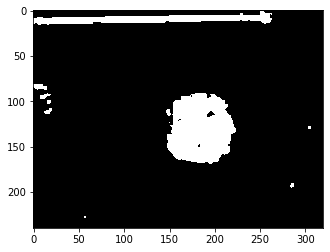

tensor([  1,   1,   1,  ..., 228, 228, 228])
tensor([28950, 28951, 28952,  ..., 54297, 54298, 54299])


In [72]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [91]:
model_path = 'circled_labels_model6_1'
centroid_path = model_path + '_centroids' + '.pkl'

In [92]:
centroids = load_centroids(centroids_path)

In [93]:
import torch.optim as optim
last_out_channel = 256
model = EmbeddingNet6(last_out_channel)

In [94]:
model.load_state_dict(torch.load(model_path+'.pt'))

<All keys matched successfully>

In [95]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (76800, 256)
flatten_labels.shape: torch.Size([76800])
zeros count: 0
not zeros count: 76800


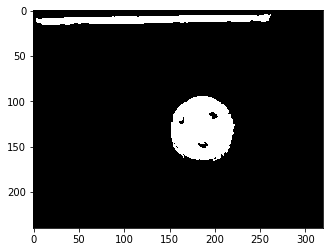

In [96]:
heat_map = get_heat_map(embeddings, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

# Video Generation with HeatMap

In [101]:
from tqdm import tqdm
import torch
import cv2
import time

def get_heatmaps(model, centroids, frames, image_shape, frames_step=1, num_classes=2, use_gpu=True):
    since = time.time()
    model.eval()
    if use_gpu:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        model = model.to(device)
    heat_maps = []
    frames_cpy = frames.copy()
    with torch.set_grad_enabled(False):
        for idx in tqdm(range(0, len(frames), frames_step), desc="Generate Heat Maps"):
            frames_cpy[idx] = np.moveaxis(frames_cpy[idx], -1, 0)
            frames_cpy[idx] = torch.tensor(frames_cpy[idx])
            frames_cpy[idx] = frames_cpy[idx].float()
            frames_cpy[idx] = frames_cpy[idx].unsqueeze(0)
            if use_gpu:
                frames_cpy[idx] = frames_cpy[idx].to(device)
            embeddings = model(frames_cpy[idx])
            if use_gpu:
                embeddings = embeddings.data.cpu().numpy()
            else:
                embeddings = embeddings.data.numpy()
            heat_map = get_heat_map(embeddings, image_shape, centroids, num_classes)
            heat_maps.append(heat_map)
    time_elapsed = time.time() - since
    print('Time Elapsed (get_heatmaps func) {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return heat_maps

def create_video(heat_maps, video_path, width, height, froucc=0, fps=1):
    since = time.time()
    video = cv2.VideoWriter(video_path, froucc, fps, (width, height), 0)
    frame = cv2.cvtColor(frames[0], cv2.COLOR_RGB2GRAY)
    for heat_map in heat_maps:
        video.write((heat_map*255).astype('uint8'))
    video.release()
    time_elapsed = time.time() - since
    print('Time Elapsed (create_video func) {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


def easy_create_video(model, centroids, frames, video_path, width, height, froucc=0, use_gpu=True, fps=1, frames_step=1, num_classes=2, ret_heat_maps=False):
    since = time.time()
    heat_maps = get_heatmaps(model, centroids, frames, (height, width), frames_step, num_classes, use_gpu)
    create_video(heat_maps, video_path, width, height, froucc, fps)
    time_elapsed = time.time() - since
    print('Time Elapsed (easy_create_video func) {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    if heat_maps: return heat_maps

In [47]:
from skimage.io import imread_collection
import os

images_path = 'data/Vid_A_ball/*.jpg'
# images = imread_collection(images_path)
image_folder = 'data/Vid_A_ball/'
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images = sorted(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
print(frame.shape)
frames = []
for image in images:
    frames.append(cv2.imread(os.path.join(image_folder, image)))
print("frames count:", len(frames))

(240, 320, 3)
frames count: 602


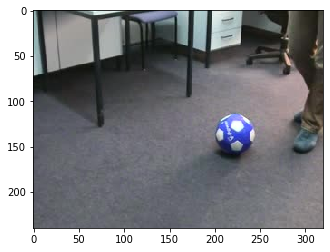

In [48]:
plt.imshow(frames[0])
plt.show()

## model5_3

In [49]:
model_path = 'model5_3'
centroids_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/1fps_'+model_path+'.avi'

In [50]:
last_out_channel = 256
model = EmbeddingNet5(last_out_channel)

In [51]:
centroids = load_centroids(centroids_path)
model.load_state_dict(torch.load('Models/' + model_path + '.pt'))

<All keys matched successfully>

In [52]:
heat_maps = easy_create_video(model, centroids, frames, video_path, width, height, ret_heat_maps=True)

Generate Heat Maps: 100%|██████████| 602/602 [25:29<00:00,  2.54s/it]


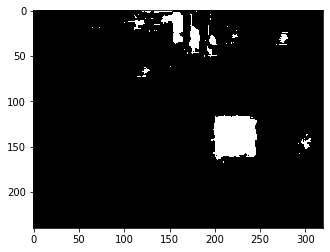

In [53]:
plt.imshow(heat_maps[6], cmap=plt.cm.gray)
plt.show()

In [54]:
video_path = 'Videos/10fps_'+model_path+'.avi'
create_video(heat_maps, video_path, width, height, 0, 10)

## Model: circled_labels_model6_1

In [55]:
model_path = 'circled_labels_model6_1'
centroids_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/1fps_'+model_path+'.avi'

In [56]:
last_out_channel = 256
model = EmbeddingNet6(last_out_channel)

In [57]:
centroids = load_centroids(centroids_path)
model.load_state_dict(torch.load('Models/' + model_path + '.pt'))

<All keys matched successfully>

In [58]:
heat_maps = easy_create_video(model, centroids, frames, video_path, width, height, ret_heat_maps=True)

Generate Heat Maps: 100%|██████████| 602/602 [25:29<00:00,  2.54s/it]


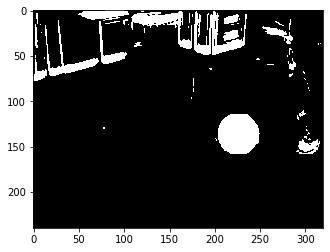

In [59]:
plt.imshow(heat_maps[3], cmap=plt.cm.gray)
plt.show()

In [60]:
video_path = 'Videos/10fps_'+model_path+'.avi'
create_video(heat_maps, video_path, width, height, 0, 10)

# Cropped Frames

## Model: circled_labels_model6_1 Cropped

In [91]:
from skimage.io import imread_collection
import os

images_path = 'data/Vid_A_ball/*.jpg'
image_folder = 'data/Vid_A_ball/'
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images = sorted(images)
start_point = (170, 120)   
end_point = (220, 170)
padding = 25
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point[0]+padding, end_point[1]+padding)
frames = []
for image in images:
    frame = cv2.imread(os.path.join(image_folder, image))
    frame = frame[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
    frames.append(frame)
height, width, layers = frames[0].shape

print(frames[0].shape)
print("frames count:", len(frames))

(100, 100, 3)
frames count: 602


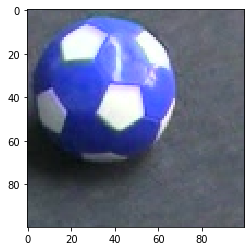

In [92]:
plt.imshow(frames[120])
plt.show()

## circled_labels_model6_1

In [93]:
model_path = 'circled_labels_model6_1'
centroids_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [94]:
last_out_channel = 256
model = EmbeddingNet6(last_out_channel)

In [95]:
centroids = load_centroids(centroids_path)
model.load_state_dict(torch.load('Models/' + model_path + '.pt'))

<All keys matched successfully>

In [96]:
heat_maps = easy_create_video(model, centroids, frames[:300], video_path, width, height, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]

Time Elapsed 0m 0s
Time Elapsed 0m 53s


## model5_3

In [102]:
model_path = 'model5_3'
centroids_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [103]:
last_out_channel = 256
model = EmbeddingNet5(last_out_channel)

In [104]:
centroids = load_centroids(centroids_path)
model.load_state_dict(torch.load('Models/' + model_path + '.pt'))

<All keys matched successfully>

In [105]:
heat_maps = easy_create_video(model, centroids, frames[:300], video_path, width, height, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]

Time Elapsed (get_heatmaps func) 1m 8s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 1m 8s


### Create Video

In [1]:
from networks import *
from functions import *
from imageloader import *

#### Load Cropped Frames

In [5]:
tar_path = 'data/'
cup_video_path = 'Vid_A_ball'

In [6]:
image_folder = tar_path + cup_video_path
frames_cropped, height_cropped, width_cropped = get_cropped_frames(image_folder)

In [7]:
model_path = 'model5_3'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_real_'+model_path+'.avi'

In [8]:
last_out_channel = 256
model = EmbeddingNet5(last_out_channel)

In [9]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [10]:
frames_step = 3

real_heat_maps = easy_create_real_video(model, centroids, frames_cropped, video_path, width_cropped,
                                        height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


Time Elapsed (get_heatmaps func) 1m 17s


<Figure size 432x288 with 0 Axes>

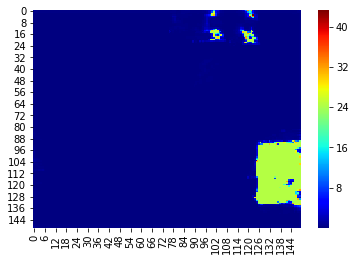

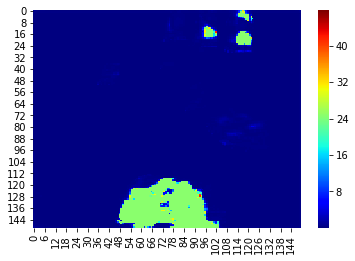

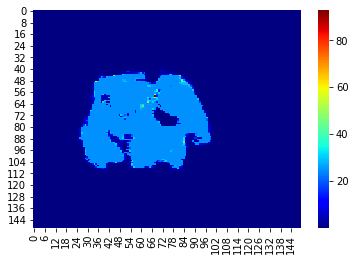

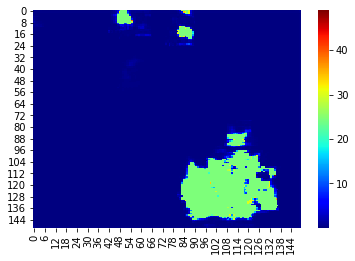

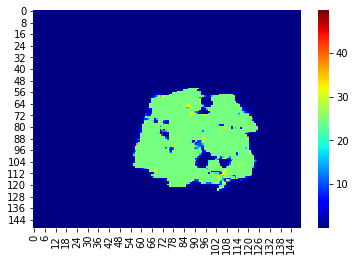

In [11]:
heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet')
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet') 
plt.show()